In [14]:
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import collections
import numpy as np

from main import plot_segments, plot_lines
from cluster import cluster_segments
from optimize import find_vanishing_points
from itertools import permutations, combinations
from linesegmentintersections import bentley_ottman

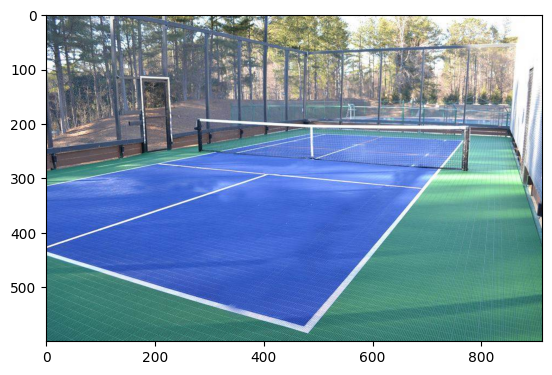

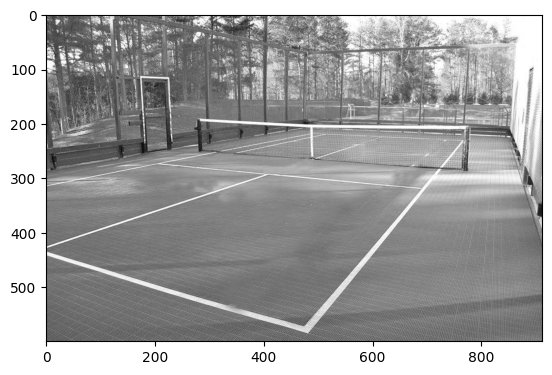

In [4]:
IM_PATH = "pb_court_1.jpg"

im = cv.cvtColor(cv.imread(IM_PATH), cv.COLOR_BGR2RGB)
im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
plt.imshow(im)
plt.figure()
plt.imshow(im_gray, cmap="gray")

# plt.figure()
# im_gaus = cv.GaussianBlur(im, (31, 31), 0)
# im_blur = cv.medianBlur(im_gray, 51)
# im_mask = np.abs(im_gray - im_blur) < 200
# plt.imshow(im_mask, cmap="gray")
# plt.imshow(im_gaus)

1418
2950


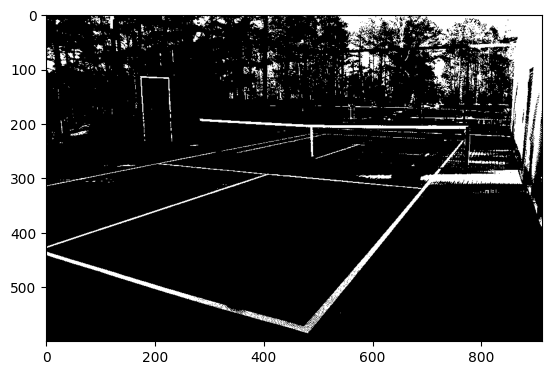

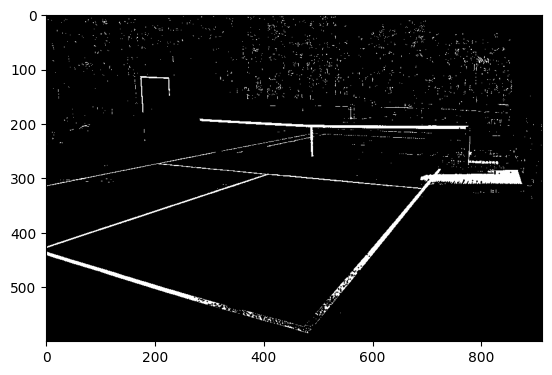

In [5]:
retval, im_thresh = cv.threshold(im_gray, 200, 255, cv.THRESH_BINARY)
plt.imshow(im_thresh, cmap="gray")
plt.figure()

area_threshold = 100

def is_bad(con, im):
    convex_area = cv.contourArea(cv.convexHull(con))
    area = cv.contourArea(con)

    if area > 1 and area / convex_area > 0.25:
        con_mask = cv.drawContours(np.zeros_like(im), [con], -1, 1, -1)
        white_ratio = np.sum(np.multiply(im, con_mask)) / np.sum(con_mask) / 255
        if white_ratio > 0.25:
            return True
    
    return False
    # return area > 1000 and area / convex_area > 0.5

contours, _ = cv.findContours(im_thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
bad_contours = [con for con in contours if is_bad(con, im_thresh)]
im_thresh_trim = cv.drawContours(im_thresh, bad_contours, -1, 0, -1)
plt.imshow(im_thresh_trim, cmap="gray")
print(len(bad_contours))
print(len(contours))

(48, 4)


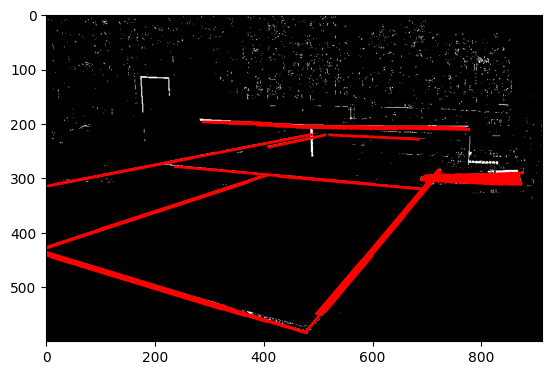

In [6]:
hough_lines = cv.HoughLinesP(
    image=im_thresh,
    rho=1,
    theta=np.pi / 180,
    threshold=75,
    minLineLength=50,
    maxLineGap=15,
)[:, 0, :]


_, ax1 = plt.subplots()
ax1.imshow(im_thresh, cmap="gray")
plot_segments(ax1, hough_lines, colors=["red"], linewidths=[2])
print(hough_lines.shape)

(11, 4)


<Figure size 640x480 with 0 Axes>

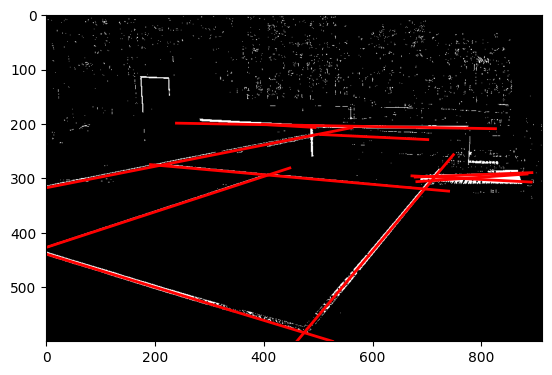

In [7]:
avg_lines = cluster_segments(hough_lines)["average_lines"]

# extend the lines by 10% per side to guarantee intersections
x1 = avg_lines[:, 0]
y1 = avg_lines[:, 1]
x2 = avg_lines[:, 2]
y2 = avg_lines[:, 3]
v12 = (avg_lines[:, 2:4] - avg_lines[:, 0:2])
extended_avg_lines = avg_lines.copy()
extended_avg_lines[:, 0:2] -= v12 * 0.1
extended_avg_lines[:, 2:4] += v12 * 0.1

plt.figure()
_, ax2 = plt.subplots()
ax2.imshow(im_thresh, cmap="gray")
plot_segments(ax2, extended_avg_lines, colors=["red"], linewidths=[2])
print(avg_lines.shape)

(0, 9)
(4, 0)

(1, 1)
(1, 4)

(1, 1)
(1, 6)

(1, 1)
(3, 1)

(1, 4)
(1, 6)

(1, 4)
(3, 1)

(1, 4)
(3, 4)

(1, 4)
(4, 0)

(1, 4)
(4, 5)

(1, 6)
(2, 6)

(1, 6)
(3, 1)

(1, 6)
(3, 6)

(2, 6)
(3, 2)

(2, 6)
(3, 6)

(3, 1)
(3, 2)

(3, 1)
(3, 4)

(3, 1)
(3, 6)

(3, 2)
(3, 4)

(3, 2)
(3, 6)

(3, 4)
(3, 6)

(3, 4)
(4, 0)

(3, 4)
(4, 5)

(4, 0)
(4, 5)

1
3
6
5
3
6
4
6
5
4
3


C:\Users\Evan Chapman\AppData\Local\Temp\ipykernel_17380\125865478.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

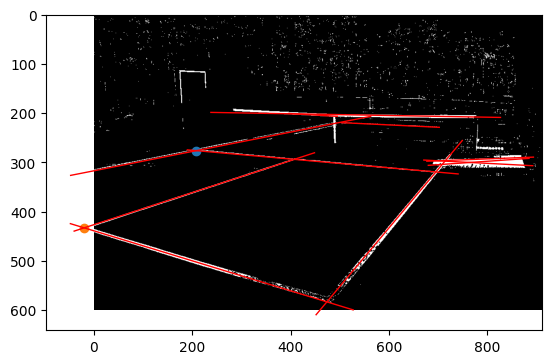

<Figure size 640x480 with 0 Axes>

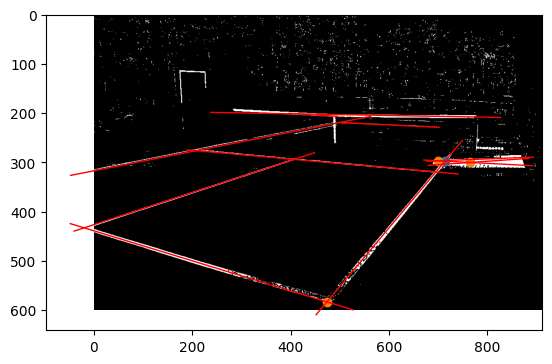

<Figure size 640x480 with 0 Axes>

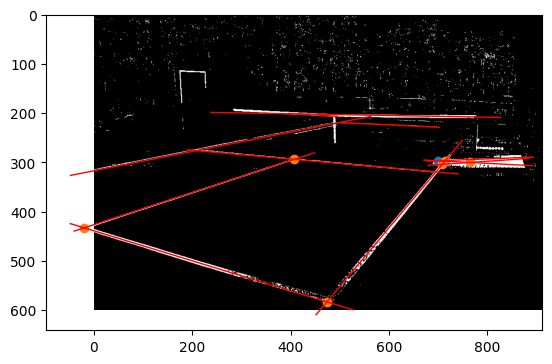

<Figure size 640x480 with 0 Axes>

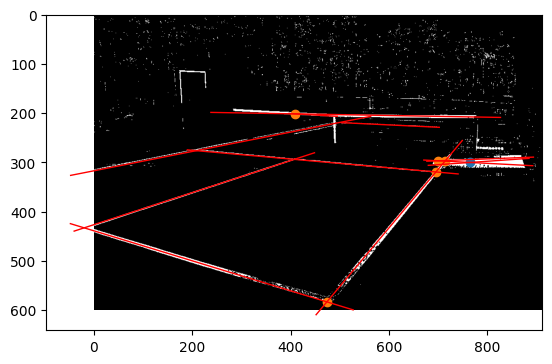

<Figure size 640x480 with 0 Axes>

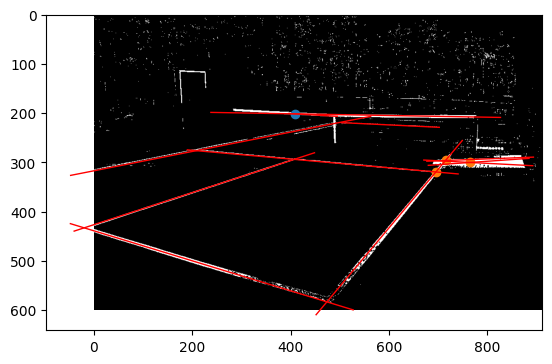

<Figure size 640x480 with 0 Axes>

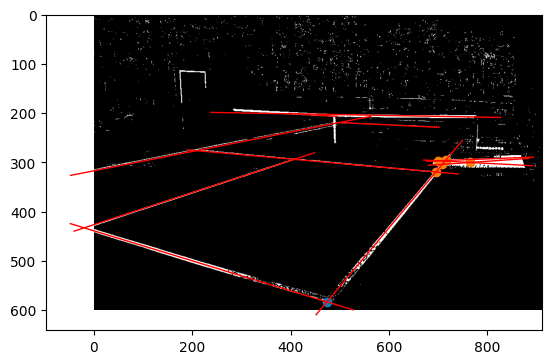

<Figure size 640x480 with 0 Axes>

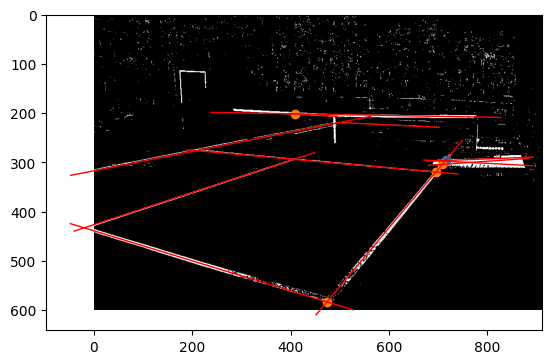

<Figure size 640x480 with 0 Axes>

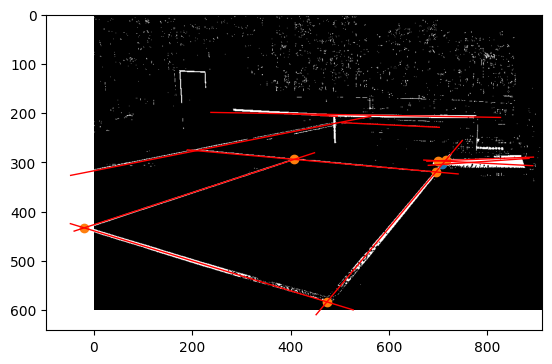

<Figure size 640x480 with 0 Axes>

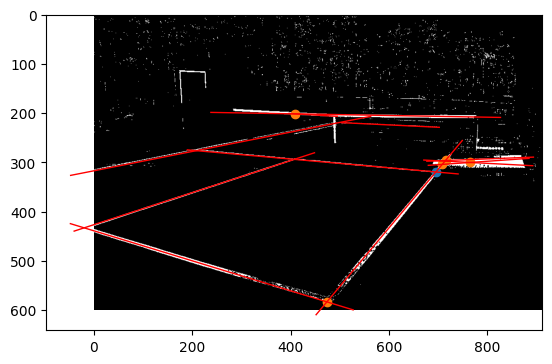

<Figure size 640x480 with 0 Axes>

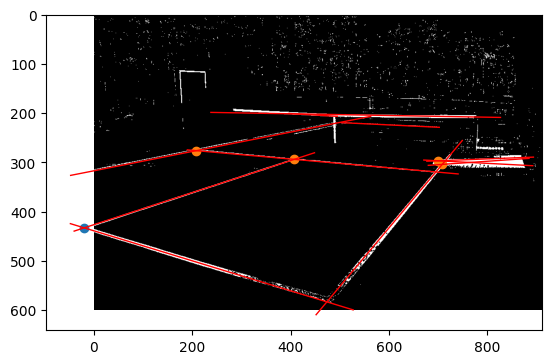

<Figure size 640x480 with 0 Axes>

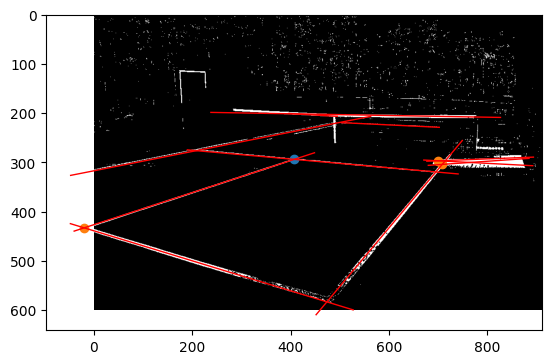

In [61]:
def get_intersection(l1: np.ndarray, l2: np.ndarray) -> np.ndarray | None:
    segments = np.asarray([[l1[:2], l1[2:]], [l2[:2], l2[2:]]]).tolist()
    intersections = bentley_ottman(segments)
    if len(intersections) > 0:
        return intersections[0].x, intersections[0].y
    else:
        return None

intersections = {}
for i, line_i in enumerate(extended_avg_lines):
    for j, line_j in enumerate(extended_avg_lines[i + 1:]):
        pt = get_intersection(line_i, line_j)
        if pt is not None:
            intersections[pt] = (i, j)

graph = {pt: [] for pt in intersections}
for pt1, pt2 in combinations(intersections, r=2):
    if set(intersections[pt1]).intersection(set(intersections[pt2])):
        graph[pt1].append(pt2)
        graph[pt2].append(pt1)
graph = {pt: np.array(children) for pt, children in graph.items()}

for children in graph.values():
    print(len(children))

for pt in graph:
    plt.figure()
    _, ax2 = plt.subplots()
    ax2.imshow(im_thresh, cmap="gray")
    plot_segments(ax2, extended_avg_lines, colors=["red"], linewidths=[1])

    ax2.scatter(x=pt[0], y=pt[1])
    ax2.scatter(x=graph[pt][:, 0], y=graph[pt][:, 1])

    
def is_pt_on_line(pt, line):
    p1 = line[:2]
    p2 = line[2:]

    v = p2 - p1
    norm_v = np.linalg.norm(v)
    v_pt = pt - p1
    norm_pt = np.linalg.norm(v_pt)

    return norm_v >= norm_pt and np.allclose(v / norm_v, v_pt / norm_pt)


# intersections = [get_intersection(l1, l2) for l1, l2 in combinations(extended_avg_lines, r=2)]
# intersections = np.array([i for i in intersections if i is not None])

# for pt in intersections:
#     assert sum(1 for line in extended_avg_lines if is_pt_on_line(pt, line)) == 2



In [48]:
print(intersections)
len(intersections)
intersections[3:]

[[208.46952307 276.19307771]
 [713.98716333 297.53338757]
 [699.61051525 296.78539013]
 [765.2171197  300.19881251]
 [409.6443662  201.39084507]
 [473.90387343 583.66808433]
 [715.11230687 296.19242542]
 [708.44665178 304.13664843]
 [695.55082463 319.50607957]
 [-19.63335817 433.15673001]
 [407.58156058 293.89882832]]


array([[765.2171197 , 300.19881251],
       [409.6443662 , 201.39084507],
       [473.90387343, 583.66808433],
       [715.11230687, 296.19242542],
       [708.44665178, 304.13664843],
       [695.55082463, 319.50607957],
       [-19.63335817, 433.15673001],
       [407.58156058, 293.89882832]])